In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [15]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

In [16]:
print(dataset.keys())
for image in dataset['train'].take(1):
    pass
print(image.keys())
print(np.max(image['segmentation_mask'].numpy()))
print(np.min(image['segmentation_mask'].numpy()))

dict_keys(['train', 'test'])
dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])
3
1


In [17]:
# Preprocessing Utilities
@tf.function
def random_flip(input_image, input_mask):
  '''does a random flip of the image and mask'''
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask

@tf.function
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


@tf.function
def load_image_train(datapoint):
  '''resizes, normalizes, and flips the training data'''
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = random_flip(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

@tf.function
def load_image_test(datapoint):
  '''resizes and normalizes the test data'''
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [18]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [29]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [30]:
class_names = ['pet', 'background', 'outline']

def display_with_metrics(display_list, iou_list, dice_score_list):
  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)
  display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string)

def display(display_list,titles=[], display_string=None):
  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  plt.show()

def show_image_from_dataset(dataset):
  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])

def plot_metrics(metric_name, title, ylim=5):
  '''plots a given metric from the model history'''
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

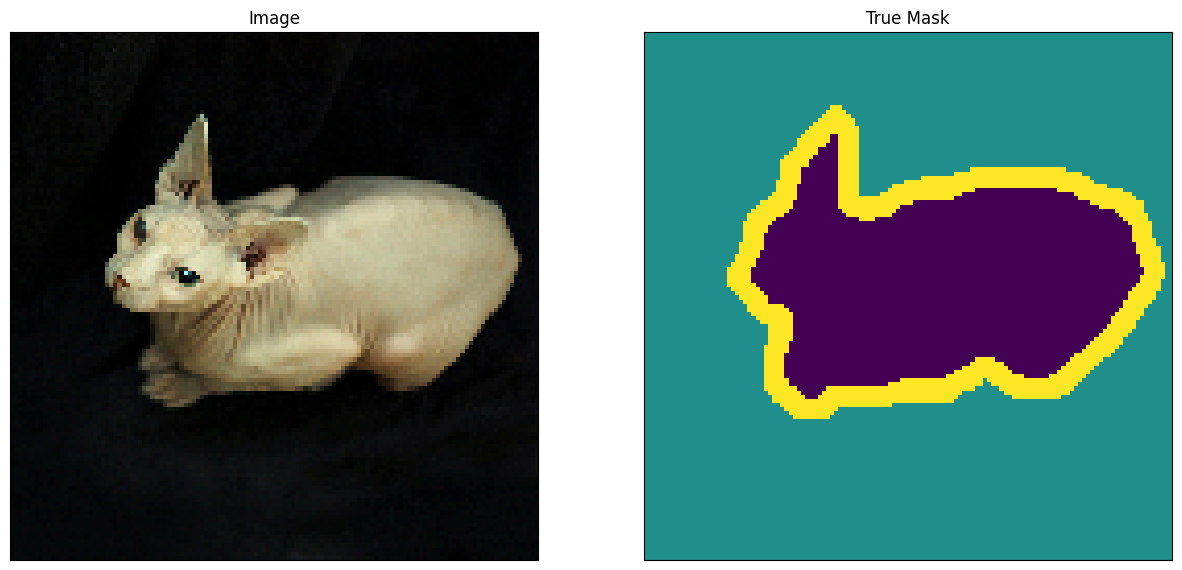

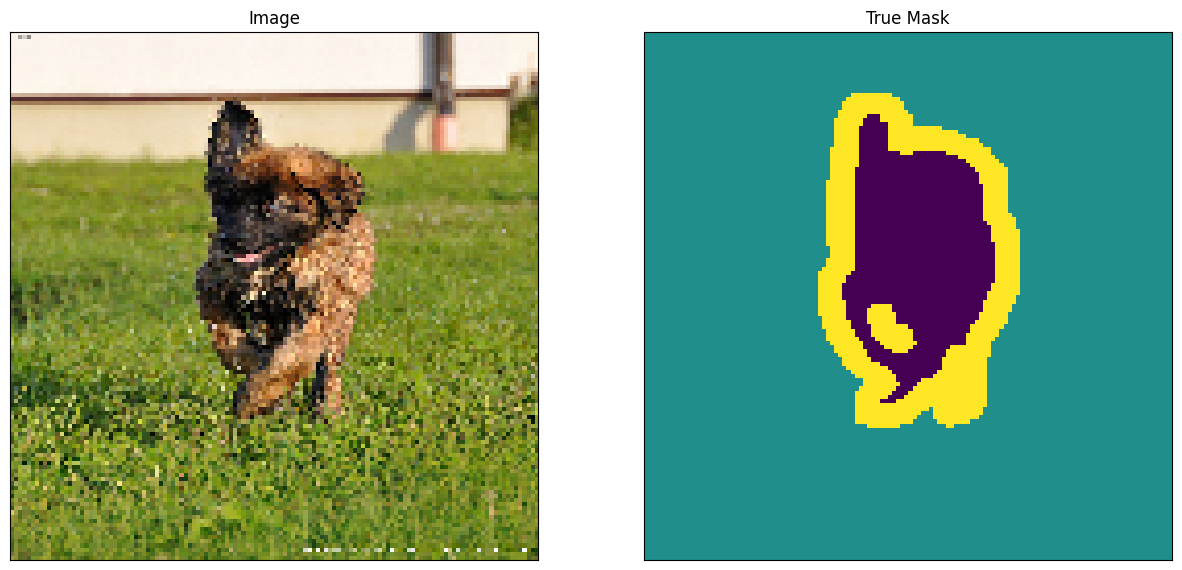

In [31]:
show_image_from_dataset(train)
show_image_from_dataset(test)

In [32]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  #Returns:tensor of output features
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  return x

def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)
  return f, p

def encoder(inputs):
  f, p = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  return p, f

In [33]:
def bottleneck(inputs):
  #This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  bottle_neck = conv2d_block(inputs, n_filters=1024)
  return bottle_neck

In [34]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  #Returns:c (tensor) -- output features of the decoder block
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)
  return c


def decoder(inputs, convs, output_channels):
  #Returns:outputs (tensor) -- the pixel wise label map of the image
  f= convs
  c = decoder_block(inputs, f, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c)
  return outputs

In [35]:
OUTPUT_CHANNELS = 3
def unet():
  #Defines the UNet by connecting the encoder, bottleneck and decoder.
  inputs = tf.keras.layers.Input(shape=(128, 128,3,))
  encoder_output, convs = encoder(inputs)
  bottle_neck = bottleneck(encoder_output)
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

model = unet()
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_12             │ (None, 128, 128, 64)   │              0 │ conv2d_14[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ activation_12[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_13             │ (None, 128, 128, 64)   │              0 │ conv2d_15[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 64)     │              0 │ activation_13[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64, 64, 64)     │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 64, 64, 1024)   │        590,848 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_14             │ (None, 64, 64, 1024)   │              0 │ conv2d_16[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 64, 64, 1024)   │      9,438,208 │ activation_14[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_15             │ (None, 64, 64, 1024)   │              0 │ conv2d_17[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 128, 128, 512)  │      4,719,104 │ activation_15[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 128, 128, 576)  │              0 │ conv2d_transpose_2[0]… │
│ (Concatenate)             │                        │                │ activation_13[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 128, 128, 576)  │              0 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 128, 128, 512)  │      2,654,720 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_16        

 Total params: 19,802,947 (75.54 MB)

 Trainable params: 19,802,947 (75.54 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Virtual devices cannot be modified after being initialized


In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 15
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=VALIDATION_STEPS,validation_data=test_dataset)

Epoch 1/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 817s 4s/step - accuracy: 0.5045 - loss: 6.5664 - val_accuracy: 0.6538 - val_loss: 0.8084
Epoch 2/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - accuracy: 0.6444 - loss: 0.7715 - val_accuracy: 0.6731 - val_loss: 0.7467
Epoch 3/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.6920 - loss: 0.7036 - val_accuracy: 0.6997 - val_loss: 0.7263
Epoch 4/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.7127 - loss: 0.6669 - val_accuracy: 0.7273 - val_loss: 0.6593
Epoch 5/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.7302 - loss: 0.6365 - val_accuracy: 0.7413 - val_loss: 0.6335
Epoch 6/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 535s 5s/step - accuracy: 0.7278 - loss: 0.6418 - val_accuracy: 0.7448 - val_loss: 0.6449
Epoch 7/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 429s 4s/step - accuracy: 0.7397 - loss: 0.6189 - val_accuracy: 0.7324 - val_loss: 0.6506
Epoch 8/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 432s 4s/step - accuracy: 0.7483 - loss: 0.6034 - val_accu

In [38]:
model.save('Unet1.h5')
print('Model is Saved')

Model is Saved


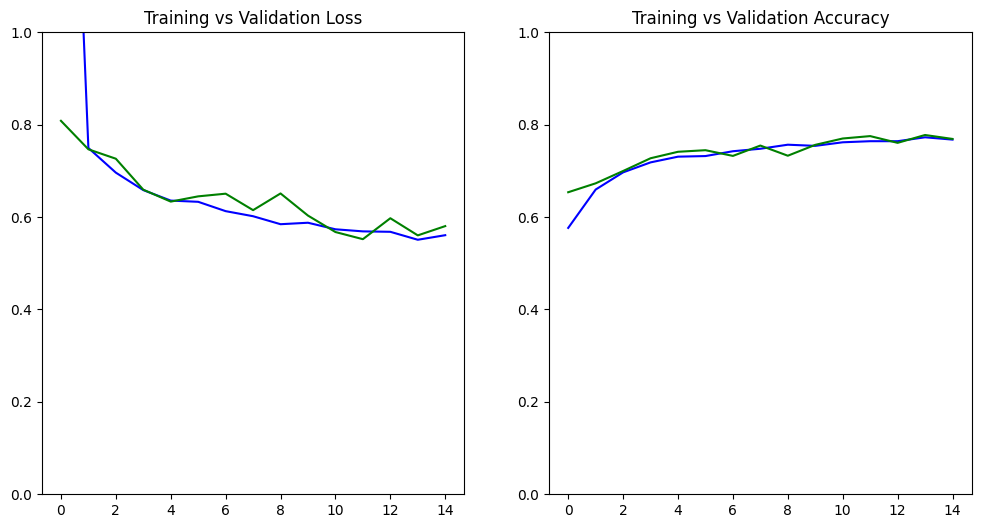

In [50]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plot_metrics("loss", title="Training vs Validation Loss", ylim=1)
plt.subplot(1,2,2)
plot_metrics("accuracy", title="Training vs Validation Accuracy", ylim=1)
plt.show()

In [40]:
# Prediction Utilities

def get_test_image_and_annotation_arrays():
  '''
  Unpacks the test dataset and returns the input images and segmentation masks
  '''
  ds = test_dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)

  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()

  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]

  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments


def create_mask(pred_mask):
  '''
  Creates the segmentation mask by getting the channel with the highest probability. Remember that we
  have 3 channels in the output of the UNet. For each pixel, the predicition will be the channel with the
  highest probability.
  '''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
  '''
  Feeds an image to a model and returns the predicted mask.
  '''

  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

In [41]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  for i in range(3):

    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [42]:
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

114/114 ━━━━━━━━━━━━━━━━━━━━ 111s 971ms/step


In [43]:
# compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [44]:
# show the IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou))

pet         0.5860868926880558 
background  0.7517992753936126 
outline     0.19012696663948786 


In [45]:
# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score))


pet         0.7390350369706671 
background  0.8583166872526501 
outline     0.3195070307104173 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


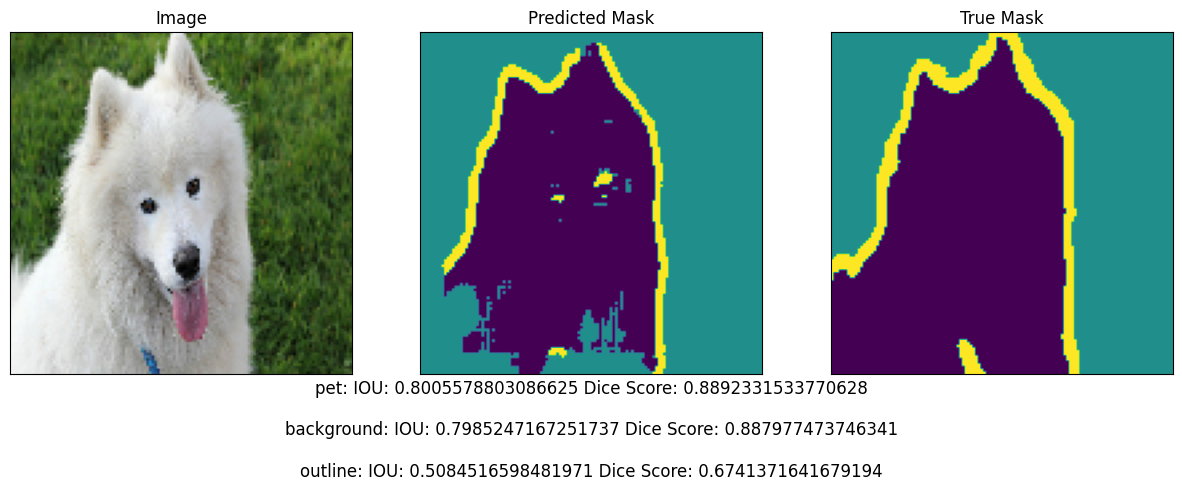

In [48]:
integer_slider = 11
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


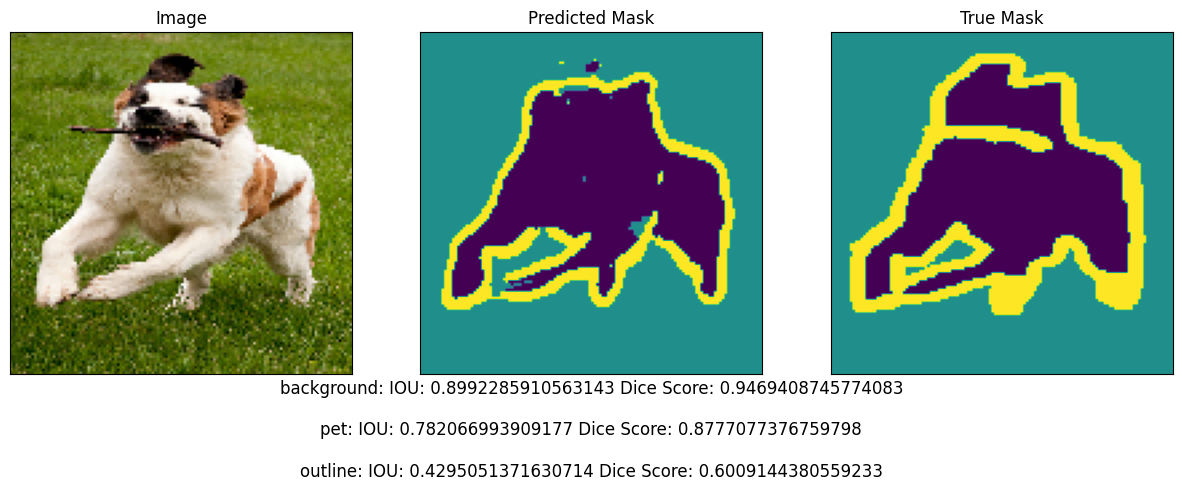

In [47]:
integer_slider = 2
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)